In [94]:
import pandas as pd
import numpy as np

data = pd.read_csv('7g-10s-10-12-r1.csv')
bp_low = 8
bp_high = 14

eeg_channels = ['EEG1', 'EEG2', 'EEG3', 'EEG4']
eeg_data = data[eeg_channels].values  # Shape: (n_samples, 4)
timestamps = data['timestamps'].values

In [95]:
from scipy.signal import butter, filtfilt, iirnotch

# ganglion sr is 200 Hz
sr = 200

def bandpass_filter(data, lowcut, highcut, fs):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, freq, fs):
    nyquist = fs / 2
    b, a = iirnotch(freq / nyquist, 30)
    return filtfilt(b, a, data, axis=0)

eeg_filtered = bandpass_filter(eeg_data, bp_low, bp_high, sr)
eeg_filtered = notch_filter(eeg_filtered, 60, sr)
print(eeg_filtered.shape)

(3614, 4)


In [96]:
windows = []
window_size = 200
step_size = 50
    
for start in range(0, len(eeg_filtered) - window_size, step_size):
    end = start + window_size
    window = eeg_filtered[start:end, :]
    windows.append(window)

print(f"Created {len(windows)} windows")
print(f"Each window shape: {windows[1].shape}")

Created 69 windows
Each window shape: (200, 4)


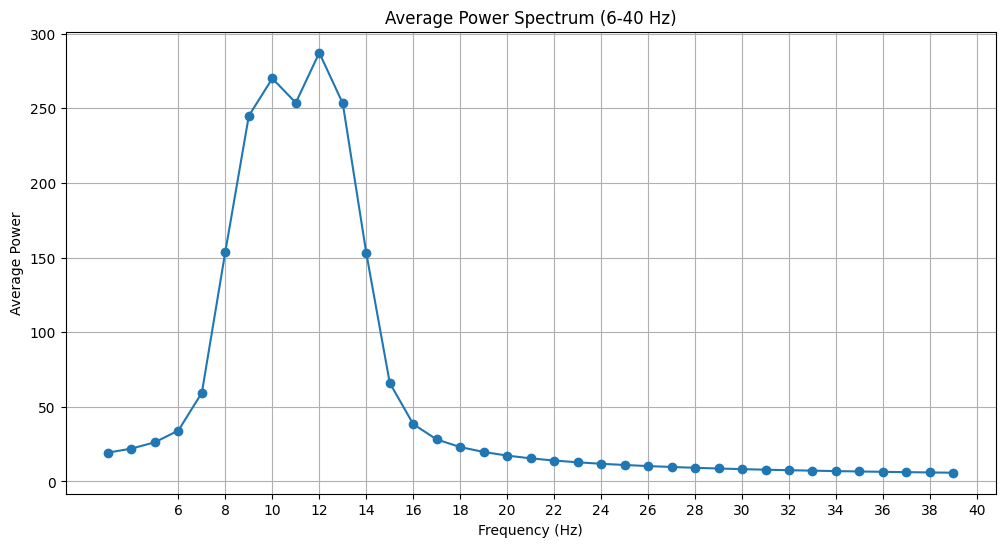

In [97]:
from scipy.fft import fft, fftfreq

n_samples = windows[0].shape[0]
n_channels = windows[0].shape[1]
sr = 200

target_freqs = range(3,40)

# Store power for each frequency across all windows
freq_powers = {freq: [] for freq in target_freqs}
  
# Process each window
for window in windows:
    # Compute FFT for each channel in this window
    for ch in range(n_channels):
        channel_data = window[:, ch]
        
        fft_values = fft(channel_data)
        fft_freqs = fftfreq(n_samples, 1/sr)
        
        power_spectrum = np.abs(fft_values[:n_samples//2])
        positive_freqs = fft_freqs[:n_samples//2]
        
        # Extract power at each target frequency
        for target_freq in target_freqs:
            idx = np.argmin(np.abs(positive_freqs - target_freq))
            freq_powers[target_freq].append(power_spectrum[idx])

# Calculate average power across all windows and channels
avg_powers = {freq: np.mean(powers) for freq, powers in freq_powers.items()}
    
import matplotlib.pyplot as plt

freqs = list(avg_powers.keys())
powers = list(avg_powers.values())

plt.figure(figsize=(12, 6))
plt.plot(freqs, powers, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Power')
plt.title('Average Power Spectrum (6-40 Hz)')
plt.grid(True)
plt.xticks(range(6, 41, 2))
plt.show()